### Load dataset


In [1]:
from sklearn.datasets import fetch_california_housing

house_dataset = fetch_california_housing()

# Import pandas package to format the data
import pandas as pd

# Extract features with their names into the a dataframe format
data = pd.DataFrame(house_dataset.data, columns=house_dataset.feature_names)

# Extract target with their names into a pd.Series object with name MEDV
target = pd.Series(house_dataset.target, name="MEDV")

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    data, target, test_size=0.2, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.2, shuffle=False
)


### Create the LightGBM model building function (search space)


In [2]:

def build_model(hp):
    model = lgb.LGBMRegressor(
        boosting_type="gbdt",
        # you can also search model type such as:
        # boosting_type=hp.Choice("model_type", ['gbdt', 'goss'], default='gbdt'),
        num_leaves=hp.Int("num_leaves", 5, 50, step=1),
        learning_rate=hp.Float("learning_rate", 1e-3, 1, sampling="log", default=0.01),
        n_estimators=hp.Int("n_estimators", 5, 50, step=1),
    )

    return model



### Customize tuner


In [3]:
import os
import pickle
import tensorflow as tf
import keras_tuner as kt
import lightgbm as lgb
from sklearn.metrics import mean_squared_error


class LightGBMTuner(kt.engine.base_tuner.BaseTuner):
    def run_trial(self, trial, X, y, validation_data):
        model = self.hypermodel.build(trial.hyperparameters)  # build the model
        model.fit(
            X_train,
            y_train,
            eval_set=[validation_data],
            eval_metric="mse",
            early_stopping_rounds=5,
        )  # fit the model
        X_val, y_val = validation_data
        y_pred = model.predict(
            X_val, num_iteration=model.best_iteration_
        )  # evaluate the model
        eval_mse = mean_squared_error(y_val, y_pred)
        self.save_model(trial.trial_id, model)  # save the model to disk
        # inform the oracle of the eval result, the result is a dictionary with the metric names as the keys.
        return {"mse": eval_mse}

    def save_model(self, trial_id, model, step=0):
        fname = os.path.join(self.get_trial_dir(trial_id), "model.txt")
        model.booster_.save_model(fname, num_iteration=model.best_iteration_)

    def load_model(self, trial):
        fname = os.path.join(self.get_trial_dir(trial.trial_id), "model.txt")
        model = lgb.Booster(model_file=fname)
        return model



### Use build-in random search algorithm to tune models


In [4]:
random_tuner = LightGBMTuner(
    oracle=kt.oracles.RandomSearch(
        objective=kt.Objective("mse", "min"), max_trials=100, seed=42
    ),
    hypermodel=build_model,
    overwrite=True,
    project_name="random_tuner",
)

random_tuner.search(X_train, y_train, validation_data=(X_val, y_val))


Trial 100 Complete [00h 00m 00s]
mse: 0.8565818768549603

Best mse So Far: 0.23592846521391297
Total elapsed time: 00h 00m 37s


### Evaluate the best discovered model


In [5]:
from sklearn.metrics import mean_squared_error

best_model = random_tuner.get_best_models(1)[0]
y_pred_test = best_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_pred_test)
print("The prediction MSE on test set: {}".format(test_mse))


The prediction MSE on test set: 0.21981983307227843


### Plot search curves


In [6]:
import matplotlib.pyplot as plt


def plot_curve(x, y, xlabel, ylabel, title):
    plt.plot(x, y)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()



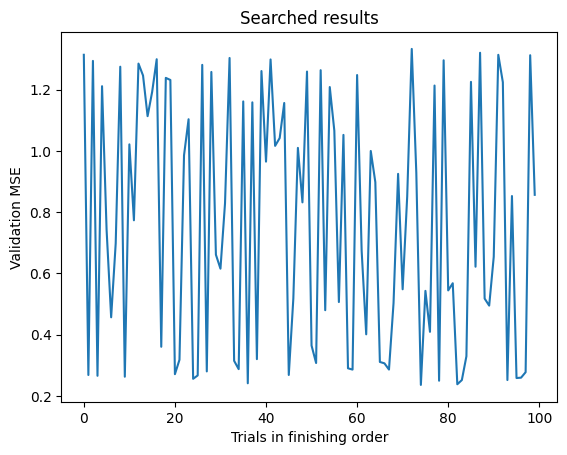

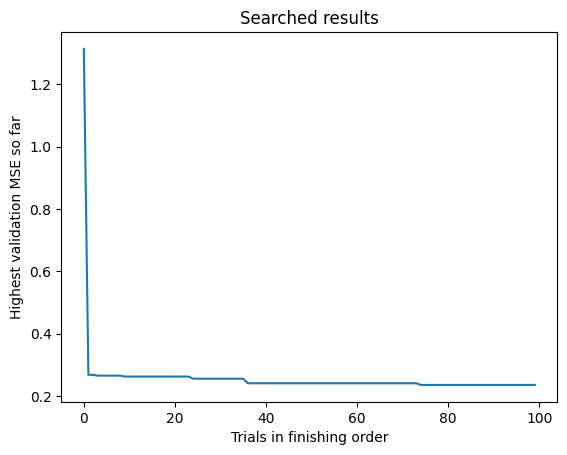

In [7]:
mse = [
    random_tuner.oracle.get_trial(trial_id).score
    for trial_id in random_tuner.oracle.end_order
]
ids = list(range(len(mse)))
plot_curve(ids, mse, "Trials in finishing order", "Validation MSE", "Searched results")

high_value = float("inf")
high_mse = []
for value in mse:
    high_value = min(high_value, value)
    high_mse.append(high_value)
plot_curve(
    ids,
    high_mse,
    "Trials in finishing order",
    "Highest validation MSE so far",
    "Searched results",
)
